# myTravel Recommender System

## Import Library

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate


2023-06-16 12:03:04.547753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 12:03:04.745957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-16 12:03:04.745992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-16 12:03:04.808474: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-16 12:03:06.117069: W tensorflow/stream_executor/pla

## Load Data

In [2]:
"""Pembuatan Dataframe"""
tourism_df = pd.read_csv("dataset/tourism_with_id_2.csv")
rating_df = pd.read_csv("dataset/tourism_rating_2.csv")

## Data Preparation

In [3]:
# Feature yang dipakai saja
data_place = tourism_df[["Place_Id", "Place_Name", "Category", "Rating", "Rating_Count"]]
rating_df = rating_df[["User_Id",	"Place_Id", "Place_Ratings"]]

In [4]:
"""Jumlah fitur"""
num_cat = len(data_place["Category"].unique())
num_user = len(rating_df["User_Id"].unique())


In [5]:
def gen_user_vecs(user_vecs, num):
  vec = []

  for i in range(num):
    vec.append(user_vecs)

  return np.array(vec)

In [10]:
data_place.head()

,Place_Id,Place_Name,Category,Rating,Rating_Count
0,1,Monumen Nasional,Budaya,4.6,1059561
1,2,Kota Tua,Budaya,4.6,28801
2,3,Dunia Fantasi,Taman Hiburan,4.6,68703
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,4.5,147578
4,5,Atlantis Water Adventure,Taman Hiburan,4.5,9126


In [11]:
rating_df

,User_Id,Place_Id,Place_Ratings
0,1,96,5
1,1,103,5
2,1,229,5
3,1,216,5
4,1,108,4
...,...,...,...
32800,1000,252,4
32801,1000,30,2
32802,1000,117,4
32803,1000,225,5


## Content-Based Filtering

In [6]:
"""Preparing place_rating dataset"""
place_prep = rating_df.copy()
place_prep = place_prep.drop("User_Id", axis=1)
place_prep = place_prep.groupby(['Place_Id']).count()
place_prep = place_prep.reset_index()


place_rating = {'Place_Id': data_place["Place_Id"].unique()}
place_rating = pd.DataFrame(place_rating)
cols_name = data_place["Category"].unique()

for i in range(num_cat):
  place_rating.insert(i+1, cols_name[i], np.zeros(len(data_place["Place_Id"].unique())), True)

for i in range(len(data_place)):
  place_rating[data_place["Category"][i]][i] = 1

place_rating.insert(7, "Rating", data_place["Rating"], True)
place_rating.insert(8, "Rating_Count", place_prep["Place_Ratings"], True)

place_rating

/tmp/ipykernel_85/4156974800.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  place_rating[data_place["Category"][i]][i] = 1


,Place_Id,Budaya,Taman Hiburan,Cagar Alam,Bahari,Pusat Perbelanjaan,Tempat Ibadah,Rating,Rating_Count
0,1,1.0,0.0,0.0,0.0,0.0,0.0,4.6,500
1,2,1.0,0.0,0.0,0.0,0.0,0.0,4.6,289
2,3,0.0,1.0,0.0,0.0,0.0,0.0,4.6,500
3,4,0.0,1.0,0.0,0.0,0.0,0.0,4.5,500
4,5,0.0,1.0,0.0,0.0,0.0,0.0,4.5,92
...,...,...,...,...,...,...,...,...,...
432,433,1.0,0.0,0.0,0.0,0.0,0.0,4.4,33
433,434,0.0,1.0,0.0,0.0,0.0,0.0,4.6,500
434,435,0.0,1.0,0.0,0.0,0.0,0.0,4.4,51
435,436,0.0,1.0,0.0,0.0,0.0,0.0,4.7,84


In [7]:
user_prep = pd.merge(rating_df, data_place)
user_prep = user_prep.drop(["Rating", "Place_Id"], axis=1)
user_prep = user_prep.groupby(['User_Id', 'Category']).mean()
user_prep.reset_index()

,User_Id,Category,Place_Ratings,Rating_Count
0,1,Bahari,4.666667,6789.666667
1,1,Budaya,4.666667,209329.833333
2,1,Cagar Alam,4.500000,27854.750000
3,1,Pusat Perbelanjaan,4.500000,19302.500000
4,1,Taman Hiburan,4.066667,20287.733333
...,...,...,...,...
5429,1000,Budaya,4.250000,33585.000000
5430,1000,Cagar Alam,4.375000,14455.250000
5431,1000,Pusat Perbelanjaan,4.666667,44406.333333
5432,1000,Taman Hiburan,4.368421,23815.368421


In [8]:
"""Preparing user rating dataset"""
user_prep = pd.merge(rating_df, data_place)
user_prep = user_prep.drop(["Rating", "Place_Id"], axis=1)
user_prep = user_prep.groupby(['User_Id', 'Category']).mean()
user_prep = user_prep.reset_index()

user_rating = {'User_Id': rating_df["User_Id"].unique()}
user_rating = pd.DataFrame(user_rating)
col_name = data_place["Category"].unique()

for i in range(num_cat):
  user_rating.insert(i+1, col_name[i], np.array([3.0]*num_user), True)

for i in range(len(user_prep)):
  user_rating[user_prep["Category"][i]][user_prep["User_Id"][i]-1] = user_prep["Place_Ratings"][i].copy()

user_rating

/tmp/ipykernel_85/4061754688.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_rating[user_prep["Category"][i]][user_prep["User_Id"][i]-1] = user_prep["Place_Ratings"][i].copy()


,User_Id,Budaya,Taman Hiburan,Cagar Alam,Bahari,Pusat Perbelanjaan,Tempat Ibadah
0,1,4.666667,4.066667,4.500000,4.666667,4.500000,3.0
1,2,4.714286,4.750000,4.000000,4.000000,3.000000,3.0
2,3,4.750000,4.125000,4.500000,3.000000,5.000000,3.0
3,4,4.600000,4.571429,3.333333,4.000000,4.666667,3.0
4,5,4.750000,4.888889,4.363636,3.000000,3.000000,5.0
...,...,...,...,...,...,...,...
995,996,4.500000,4.666667,4.500000,4.333333,4.500000,5.0
996,997,4.636364,4.571429,4.600000,3.500000,4.500000,3.0
997,998,4.600000,4.500000,4.250000,5.000000,4.000000,3.0
998,999,4.750000,4.625000,4.857143,3.000000,5.000000,5.0


In [9]:
"""Making place_rating and user_rating the same length with rating_df"""

place_ratings = rating_df.merge(place_rating, how="left", on="Place_Id")
place_ratings = place_ratings.drop(["User_Id", "Place_Id", "Place_Ratings"], axis=1)

user_ratings = rating_df.merge(user_rating, how="left", on="User_Id")
user_ratings = user_ratings.drop(["User_Id", "Place_Id", "Place_Ratings"], axis=1)

y = np.array(rating_df["Place_Ratings"])

In [10]:
# Preprocessing, Normalizing Data

# Place
place_train = place_ratings.copy()
place_train["Rating"] = (place_train["Rating"]-3)/2
place_train["Rating_Count"] = (place_train["Rating_Count"])/50

# User
user_train = user_ratings.copy()
user_train = (user_train-3)/2


# Target
y_train = y.copy()
y_train = (y_train-3)/2


In [11]:
"""Split to train and test"""

place_train, place_test = train_test_split(place_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"place training data shape: {user_train.shape}")
print(f"place test data shape: {user_test.shape}")

place training data shape: (26244, 6)
place test data shape: (6561, 6)


In [12]:
# Modelling
num_outputs = 8



tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([ 
    tf.keras.layers.Dense(16, activation='linear'),
    tf.keras.layers.Dense(num_outputs, activation='linear')
])

item_NN = tf.keras.models.Sequential([   
    tf.keras.layers.Dense(16, activation='linear'),
    tf.keras.layers.Dense(num_outputs, activation='linear')
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_cat))
vu = user_NN(input_user)


# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_cat+2))
vm = item_NN(input_item)



# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

2023-06-16 12:03:57.435047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-16 12:03:57.435090: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-16 12:03:57.435110: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-3c85a2c7-57f1-4402-bc51-41180ba04a5d): /proc/driver/nvidia/version does not exist
2023-06-16 12:03:57.435469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "model"
_____________________________________________________________

In [13]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=cost_fn,
              metrics=[tf.keras.metrics.CosineSimilarity(axis=1)]
              )
history = model.fit([user_train, place_train], y_train, validation_split=0.2, epochs=20)

Epoch 1/20
657/657 [==============================] - 3s 3ms/step - loss: 0.2372 - cosine_similarity: 0.8663 - val_loss: 0.1648 - val_cosine_similarity: 0.8897
Epoch 2/20
657/657 [==============================] - 2s 3ms/step - loss: 0.1561 - cosine_similarity: 0.9003 - val_loss: 0.1604 - val_cosine_similarity: 0.8897
Epoch 3/20
657/657 [==============================] - 2s 3ms/step - loss: 0.1483 - cosine_similarity: 0.9003 - val_loss: 0.1614 - val_cosine_similarity: 0.8897
Epoch 4/20
657/657 [==============================] - 2s 3ms/step - loss: 0.1438 - cosine_similarity: 0.9011 - val_loss: 0.1428 - val_cosine_similarity: 0.8905
Epoch 5/20
657/657 [==============================] - 2s 3ms/step - loss: 0.1403 - cosine_similarity: 0.9021 - val_loss: 0.1375 - val_cosine_similarity: 0.8924
Epoch 6/20
657/657 [==============================] - 2s 3ms/step - loss: 0.1376 - cosine_similarity: 0.9022 - val_loss: 0.1402 - val_cosine_similarity: 0.8927
Epoch 7/20
657/657 [====================

In [20]:
print(history.history.keys())

dict_keys(['loss', 'cosine_similarity', 'val_loss', 'val_cosine_similarity'])


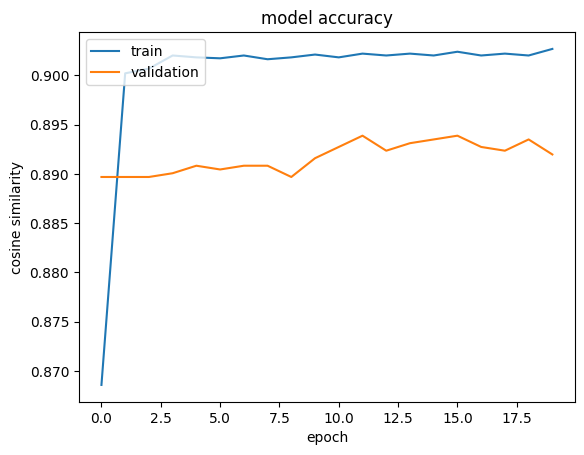

In [64]:
plt.plot(history.history['cosine_similarity'])
plt.plot(history.history['val_cosine_similarity'])
plt.title('model accuracy')
plt.ylabel('cosine similarity')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

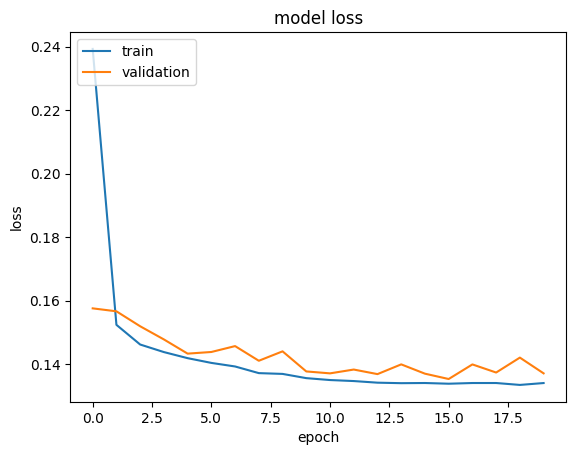

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
model.evaluate([user_test, place_test], y_test)          

206/206 [==============================] - 0s 2ms/step - loss: 0.1355 - cosine_similarity: 0.9035


[0.13551007211208344, 0.9035207033157349]

## Test Model

In [21]:
# Predictions for New User

"""
# sort the results, highest prediction first
sorted_index = np.argsort((-y_pu),axis=0).reshape(-1).tolist() #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = data_place.copy()
sorted_items = sorted_items.loc[sorted_index,:]  #using unscaled vectors for display
sorted_items.insert(4, "yp", sorted_ypu.flatten())
sorted_items.set_index("Place_Id").head(20)
"""

rate_Budaya = 5
rate_Taman_Hiburan = 3
rate_Cagar_Alam = 3
rate_Bahari = 3
rate_Pusat_Perbelanjaan	= 3
rate_Tempat_Ibadah = 3

user_vec = [rate_Budaya, rate_Taman_Hiburan, rate_Cagar_Alam,
                      rate_Bahari, rate_Pusat_Perbelanjaan, rate_Tempat_Ibadah]

# generate and replicate the user vector to match the number movies in the data set.
user_vecs = np.array(gen_user_vecs(user_vec,len(place_rating)))
item_vecs = place_rating.drop("Place_Id", axis=1).copy()



# scale our user and item vectors
suser_vecs = (user_vecs-3)/2
sitem_vecs = item_vecs.copy()
sitem_vecs["Rating"] = (sitem_vecs["Rating"]-3)/2
sitem_vecs["Rating_Count"] = (sitem_vecs["Rating_Count"])/50

# make a prediction
y_p = model.predict([suser_vecs, sitem_vecs])

# unscale y prediction 
y_pu = y_p*2+3
sorted_index = np.argsort((-y_pu),axis=0).reshape(-1).tolist() #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = data_place.copy()
sorted_items = sorted_items.loc[sorted_index,:]  #using unscaled vectors for display
sorted_items.insert(4, "yp", sorted_ypu.flatten())
sorted_items.set_index("Place_Id").head(20)

14/14 [==============================] - 0s 1ms/step


,Place_Name,Category,Rating,yp,Rating_Count
Place_Id,,,,,
124,Kauman Pakualaman Yogyakarta,Budaya,4.9,4.820317,13
115,Monumen Sanapati,Budaya,4.8,4.775742,57
150,Wisata Kraton Jogja,Budaya,4.8,4.775517,266
171,Candi Ijo,Budaya,4.8,4.774733,1015
348,Pura Giri Natha,Budaya,4.8,4.774620,1130
49,Galeri Indonesia Kaya,Budaya,4.8,4.774396,1332
70,Perpustakaan Nasional,Budaya,4.8,4.768228,6766
409,Rumah Batik,Budaya,4.7,4.731278,61
345,Kampoeng Djadhoel Semarang,Budaya,4.7,4.731278,119


In [ ]:
"""Predictions for Hidden Gems"""


# sort the results, highest prediction first
sorted_gems = data_place.copy()
sorted_gems = sorted_gems.loc[sorted_index,:]  #using unscaled vectors for display
sorted_gems.insert(4, "yp", sorted_ypu.flatten())
sorted_gems.insert(4, "Rating_Count", place_prep.drop("Place_Id", axis=1))
sorted_gems = sorted_gems.loc[sorted_gems["Rating_Count"] <= 20]
sorted_gems = sorted_gems.loc[sorted_gems["Rating"] >= 4.5]
sorted_gems.set_index("Place_Id").head(20)

## Convert Model to tflite Format

In [31]:
export_dir = "./recommender_3"
tf.saved_model.save(model, export_dir = export_dir)

INFO:tensorflow:Assets written to: ./recommender_3/assets


In [32]:
optimization = tf.lite.Optimize.DEFAULT
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
tflite_model = converter.convert()

2023-06-15 12:36:47.370987: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-15 12:36:47.371032: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-15 12:36:47.371882: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ./recommender_3
2023-06-15 12:36:47.375743: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-15 12:36:47.375782: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: ./recommender_3
2023-06-15 12:36:47.382475: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-06-15 12:36:47.384626: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-06-15 12:36:47.435258: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: ./recommender_3
2023-06-15

In [33]:
tflite_model_file = pathlib.Path('./recommender_3.tflite')
tflite_model_file.write_bytes(tflite_model)

5308

## Convert Model to JSON format

In [14]:
saved_model_path = "./recommender.h5"

model.save(saved_model_path)

In [17]:
!tensorflowjs_converter --input_format=keras "./recommender.h5" ./

2023-06-16 12:06:49.906755: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 12:06:49.961485: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 12:06:49.962093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 12:06:50.892453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c85a2c7-57f1-4402-bc51-41180ba04a5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>